### Cancer Survival Experiment OS

In [15]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import statsmodels.stats.multitest as multi
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lifelines.statistics import logrank_test

In [4]:
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from scipy import stats

In [5]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [6]:
random_state=75

In [7]:
def make_surv_df(surv,surv_type,raw):
    
    '''
    make TCGA survival dataframe
    '''
    
    #get survival dataframe
    surv=pd.read_csv(surv,index_col=0)
    surv=surv.rename(columns={"bcr_patient_barcode":"FID"})
    surv=surv[surv["Redaction"].isnull()]
    
    #get phenos
    raw=pd.read_csv(raw,delim_whitespace=True,index_col=0)
    raw=raw.iloc[:,5:]
    raw=raw.reset_index()
    raw=raw.rename(columns={"index":"FID"})

    #combine dataframes
    full_surv=pd.merge(surv[["FID",surv_type,surv_type+".time","age_at_initial_pathologic_diagnosis","race","gender","ajcc_pathologic_tumor_stage"]], raw, on="FID", how="left")
    #full_surv=full_surv[full_surv[surv_type+".time"]<1825] #censor at 5 years
    #get patients with Stage designations
    full_surv=full_surv[full_surv["ajcc_pathologic_tumor_stage"].str.contains("Stage")]
    full_surv=full_surv[~(full_surv["ajcc_pathologic_tumor_stage"].isin(["Stage X"]))]
    #split A,B,C from stage designations
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("A").str[0]
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("B").str[0]
    full_surv["ajcc_pathologic_tumor_stage"]=full_surv["ajcc_pathologic_tumor_stage"].str.split("C").str[0]
    print(full_surv.shape)
    full_surv=full_surv.join(pd.get_dummies(full_surv["ajcc_pathologic_tumor_stage"]))
    #remap gender
    full_surv["gender"]=full_surv["gender"].map({"MALE":0,"FEMALE":1})
    
    full_surv=full_surv[~full_surv[surv_type].isnull()]
    full_surv=full_surv[~full_surv[surv_type+".time"].isnull()]
    
    full_surv=full_surv[~full_surv["age_at_initial_pathologic_diagnosis"].isnull()]
    
    #map to cancer type
    canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
    mp = canc.set_index(2)[0].to_dict()
    full_surv["cancer"]=full_surv["FID"].map(mp)
    full_surv=full_surv[~full_surv["cancer"].isnull()]
    
    full_surv['ajcc_pathologic_tumor_stage'] = full_surv['ajcc_pathologic_tumor_stage'].replace({'Stage 0':0,'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4})
    
    return(full_surv)

In [8]:
def run_surv_plot(df_annot,surv_df,surv_type,out):
    
    '''
    plot kaplan meier for each snp in df_annot
    '''
    for i,row in df_annot.iterrows():
        try:
            surv_df_canc=surv_df[surv_df["cancer"]==row["cancer"]]
            x=[x for x in surv_df.columns if row["snps"].rsplit(":",2)[0] in x][0]
            rs=x.rsplit(":",2)[0]
        
            allele1=x.split(":")[2]
            allele2=str(x.split("_")[0]).split(":")[3]
            minor=x.split("_")[1]
            if allele1 == minor:
                major=allele2
            else:
                major=allele1
            
            fig=plt.figure(figsize=(12,5))
            ax1 = plt.subplot(1,2,1)
            
            groups = surv_df_canc[x]
            ix0 = (groups == 0)
            ix1 = (groups == 1)
            ix2 = (groups == 2)

            kmf = KaplanMeierFitter()
            kmf.fit(surv_df_canc[surv_type+'.time'][ix2], surv_df_canc[surv_type][ix2],label=minor+minor)
            kmf.plot(color='green', ci_show=False, ax=ax1)
            
            kmf.fit(surv_df_canc[surv_type+'.time'][ix1], surv_df_canc[surv_type][ix1],label=major+minor)
            kmf.plot(ax=ax1, color='orange', ci_show=False)
    
            kmf.fit(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type][ix0],label=major+major)
            kmf.plot(ax=ax1, color='blue', ci_show=False)

            results = logrank_test(surv_df_canc[surv_type+'.time'][ix0], surv_df_canc[surv_type+'.time'][ix2],event_observed_A=surv_df_canc[surv_type][ix0], event_observed_B=surv_df_canc[surv_type][ix2], alpha=.95) 
            plt.title('{}\n{}\nLog-rank test: p<{:.3}'.format(x,row["cancer"],results.p_value))

            plt.ylabel('% survival')
            plt.xlabel(surv_type+' time (days)')
            plt.legend(frameon=False)

            plt.tight_layout()

            plt.savefig(out+surv_type+"."+x+"."+row["cancer"]+'.pdf')
            plt.close()
        except:
            pass
        

In [9]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get associations

In [10]:
snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
snps["rsid"].to_csv("/cellar/users/tsears/projects/germline-immune/data/TIME_rsids.txt",sep="\t",header=False,index=False)
snps_bed=snps
snps_bed["chr"]=snps_bed["proxy_variant"].str.rsplit(":",0).str[0]
snps_bed["pos"]=snps_bed["proxy_variant"].str.rsplit(":",0).str[1]
snps_bed["pos2"]=snps_bed["proxy_variant"].str.rsplit(":",0).str[1]
snps_bed["ID"]=0
snps_bed[["chr","pos","pos2","ID"]].to_csv("/cellar/users/tsears/projects/germline-immune/data/TIME_rsids.bed",sep="\t",header=False,index=False)

    

In [11]:
fdr_thresh=0.05

In [12]:
surv_fdr=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_6.csv",index_col=0)

In [14]:
prog_snps=surv_fdr[surv_fdr["P"]<fdr_thresh]["ID"].unique().tolist()
prog_snps=[x.split("_")[0] for x in prog_snps]

In [ ]:
#check how many snps are associated with survival in multiple cancer types
surv_number=surv_fdr[surv_fdr["P"]<fdr_thresh][["ID","cancer"]].drop_duplicates().groupby(["ID"]).size().reset_index()
surv_number=surv_number.sort_values(by=0,ascending=False)
surv_number["snp_noallele"]=surv_number["ID"].str.rsplit(":",2).str[0]
snp_sig=snps[snps["snp_noallele"].isin(surv_number[surv_number[0]>1]["snp_noallele"].tolist())]

In [ ]:
snp_sig=snp_sig.loc[~snp_sig["proxy_variant"].duplicated()]

In [ ]:
surv=pd.read_csv("clinical_PANCAN_patient_with_followup.tsv",delimiter="\t",encoding="unicode_escape")
keep=pd.read_csv("surv_var_keep_MP.csv") #keep only curated survival variables
surv_clean=surv[["acronym"]+keep["var"].tolist()]

total_counts=pd.DataFrame()
for x in surv_clean.columns[2:]:
    surv_not_null=surv_clean[~surv_clean[x].isnull()]
    print(x)
    try:
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Not Av"))]
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Not Ap"))]
        surv_not_null=surv_not_null[~(surv_not_null[x].str.contains("Unk"))]
        df_counts=surv_not_null["acronym"].value_counts().reset_index()
        df_counts["var"]=x
        total_counts=total_counts.append(df_counts)
    except:
        df_counts=surv_not_null["acronym"].value_counts().reset_index()
        df_counts["var"]=x
        total_counts=total_counts.append(df_counts)
supp_table=total_counts.groupby('index')['var'].apply(lambda x: ','.join(x)).reset_index()
supp_table.loc[14]["var"]='history_of_neoadjuvant_treatment,radiation_therapy,height,weight,T2_pathologic_T,T3_pathologic_T,T4_pathologic_T,M1_pathologic_M,N1_pathologic_N,G1_neoplasm_histologic_grade,G2_neoplasm_histologic_grade,G3_neoplasm_histologic_grade,G4_neoplasm_histologic_grade,alcohol,NAFLD,hepatitis'
supp_table.loc[15]["var"]='radiation_therapy,targeted_molecular_therapy,T2_pathologic_T,T3_pathologic_T,T4_pathologic_T,M1_pathologic_M,N1_pathologic_N,N2_pathologic_N,N3_pathologic_N,Current smoker_tobacco_smoking_history,Lifelong Non-smoker_tobacco_smoking_history'
supp_table.loc[26]["var"]='radiation_therapy,history_of_undescended_testis,T2_pathologic_T,M1_pathologic_M,N1_pathologic_N,N2_pathologic_N'
supp_table.loc[29]["var"]='radiation_therapy,height,weight,hypertension,G2_neoplasm_histologic_grade,G3_neoplasm_histologic_grade,High Grade_neoplasm_histologic_grade,Peri (6-12 months since last menstrual period)_menopause_status,Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)_menopause_status,Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)_menopause_status'

for x in surv_clean.columns:
    try:
        m = surv_clean[x].str.contains('\[', na=False)
        surv_clean.loc[m,x] = np.nan
    except:
        pass

# map variables to category
mp_map={'Equivocal':np.nan,
 'Indeterminate':np.nan,
 'NO':0,
 'Negative':0,
 'No':0,
 'Not Performed':np.nan,
 'Positive':1,
 'YES':1,
 'Yes':1,
 'Yes, Pharmaceutical Treatment Prior to Resection':1,
 'Yes, Radiation Prior to Resection':1,
 'Yes; bilateral':1,
 'Yes; left testicle only':1,
 'Yes; right testicle only':1,
 'negative':0,
 'positive':1,
}
for var in keep[keep["coding"]=="map"]["var"].unique():
    surv_clean[var]=surv_clean[var].map(mp_map)  

#clean staging
surv_clean["pathologic_T"]=surv_clean["pathologic_T"].str[0:2]
surv_clean["pathologic_N"]=surv_clean["pathologic_N"].str[0:2]
surv_clean["pathologic_M"]=surv_clean["pathologic_M"].str[0:2]
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("A","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("B","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].str.replace("C","")
surv_clean["pathologic_stage"]=surv_clean["pathologic_stage"].replace("Stage X",np.nan)
surv_clean['pathologic_stage'] = surv_clean['pathologic_stage'].replace({'Stage 0':0,'Stage I': 1,'Stage II': 2,'Stage III': 3,'Stage IV': 4,'Stage IS':0,'I or II NOS':0})

#dummy code specified variables
mp_dummy={}
for x in keep[keep["coding"]=="dummy"]["var"].unique():
    print(x)
    df_dummy=pd.get_dummies(surv_clean[x])
    df_dummy.columns=[col+"_"+x for col in df_dummy.columns]
    mp_dummy[x]=df_dummy.columns.tolist()
    surv_clean=surv_clean.join(df_dummy)
    del surv_clean[x]
    if "None" in surv_clean.columns:
        del surv_clean["None"]
    if "Other" in surv_clean.columns:
        del surv_clean["Other"]
    
surv=pd.read_csv("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv")
surv=surv[["bcr_patient_barcode","gender","age_at_initial_pathologic_diagnosis","type","OS","OS.time","PFI","PFI.time"]]
surv=pd.merge(surv,surv_clean,on="bcr_patient_barcode",how="left")
surv["gender"]=surv["gender"].map({"MALE":0,"FEMALE":1})

del surv["T0_pathologic_T"]
del surv["TX_pathologic_T"]
del surv["Ti_pathologic_T"]
del surv["T1_pathologic_T"]

del surv["MX_pathologic_M"]
del surv["cM_pathologic_M"]
del surv["M0_pathologic_M"]

del surv["N0_pathologic_N"]
del surv["NX_pathologic_N"]

del surv["Indeterminate (neither Pre or Postmenopausal)_menopause_status"]
del surv["No History of Primary Risk Factors_hist_hepato_carc_fact"]
del surv["Other_hist_hepato_carc_fact"]
del surv["lymph_node_examined_count"]
del surv["synchronous_colon_cancer_present"]
del surv["pathologic_stage"]

del surv["GX_neoplasm_histologic_grade"]
del surv["G1_neoplasm_histologic_grade"]

del surv["Current Reformed Smoker, Duration Not Specified_tobacco_smoking_history"]
del surv["Current reformed smoker for < or = 15 years_tobacco_smoking_history"]
del surv["Current reformed smoker for > 15 years_tobacco_smoking_history"]
del surv["history_of_neoadjuvant_treatment"]

surv["alcohol"]=surv[[x for x in surv.columns if "Alcohol consumption" in x]].sum(axis=1)
surv["NAFLD"]=surv[[x for x in surv.columns if "Nonalcoholic Fatty Liver Diseas" in x]].sum(axis=1)
surv["hepatitis"]=surv[[x for x in surv.columns if "Hepatitis" in x]].sum(axis=1)



In [ ]:
#merge snps onto clinical file
raw=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",delim_whitespace=True)
raw=raw.rename(columns={"FID":"bcr_patient_barcode"})
surv=pd.merge(surv,raw,on="bcr_patient_barcode")

In [ ]:
#get snps
prog_snps=surv_fdr[surv_fdr["P"]<fdr_thresh]["ID"].unique().tolist()
prog_snps=[x.split("_")[0] for x in prog_snps]

rsid_lst=[]
for snp in prog_snps:
    try:
        rsid_lst.append([x for x in surv.columns if snp.rsplit(":",2)[0] in x][0])
    except:
        print(snp)

In [ ]:
canc_counts=surv_clean["acronym"].value_counts().reset_index()
canc_keep=canc_counts[canc_counts["acronym"]>100]["index"].tolist()

In [ ]:
#Create OS surv dataframe and split 70/30 by each cancer type

os_surv=make_surv_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","OS","/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw")
pfi_surv=make_surv_df("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv","PFI","/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw")


In [ ]:
from sklearn.model_selection import train_test_split

os_test=pd.DataFrame()
os_train=pd.DataFrame()

for cancer in np.unique(os_surv["cancer"]):
    
    temp_train,temp_test=train_test_split(os_surv[os_surv["cancer"]==cancer],test_size=0.3,random_state=random_state)
    os_test=os_test.append(temp_test)
    os_train=os_train.append(temp_train)

surv_filt=surv.drop(["gender","age_at_initial_pathologic_diagnosis","type","OS","OS.time","PFI","PFI.time","acronym"],axis=1)
surv_filt=surv_filt.drop(surv_filt.filter(like=":").columns.values,axis=1)

#merge additional covariates into df
os_test=pd.merge(os_test,surv_filt,left_on="FID",right_on="bcr_patient_barcode")
os_train=pd.merge(os_train,surv_filt,left_on="FID",right_on="bcr_patient_barcode")


In [ ]:
#run coxph analysis on test datasets, keep cov column for analysis on training datasets

df_coxph = pd.DataFrame()
cancer_test=[]
cov_cols=[]

for i,row in supp_table[supp_table["index"].isin(canc_keep)].iterrows():
    print(row["index"])
    
    for snp in rsid_lst:
        temp_df = os_test[os_test["cancer"]==row["index"]]
        temp_df=temp_df[~temp_df[snp].isnull()]
        
        if len(temp_df[snp].value_counts())>1:       
            cov_col=row["var"].split(",")
            for x in cov_col:
                if x in [x for x in mp_dummy.keys()]:
                    cov_col=cov_col+mp_dummy[x]
            cov_col=[x for x in cov_col if x in surv.columns]
            cov_col=[x for x in cov_col if len(temp_df[x].value_counts()) > 1]
            
            if len(temp_df["gender"].value_counts())>1:
                temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"gender","OS",'OS.time']+cov_col]
            else:
                temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"OS",'OS.time']+cov_col]
                
            #possibly use this line?
            #temp_df=temp_df.drop(list(temp_df.var().index[temp_df.var()<0.01]),axis=1)
            
            temp_df=temp_df.fillna(0)
            cph = CoxPHFitter(penalizer=0.01)
            cph.fit(temp_df, event_col="OS", duration_col='OS.time')
            cancer_test.append(row["index"])
            cov_cols.append(cov_col)
            df_coxph  = df_coxph.append(cph.summary.loc[[snp]])


In [ ]:
x=pd.DataFrame(zip(cancer_test,cov_cols))
cov_col_table=x[~x[0].duplicated()]
cov_col_table=cov_col_table.set_index(0)
cov_col_table["index"]=cov_col_table.index

In [ ]:
#run coxph analysis on TRAIN datasets, use cov column from analysis on test datasets

df_coxph_train = pd.DataFrame()
cancer_train=[]

for i,row in cov_col_table.iterrows():
    print(row["index"])
    
    for snp in rsid_lst:
        temp_df = os_train[os_train["cancer"]==row["index"]]
        temp_df=temp_df[~temp_df[snp].isnull()]
        
        cov_col=row[1]
            
        if max(temp_df[snp])==0:
            continue
        if len(temp_df["gender"].value_counts())>1:
            temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"gender","OS",'OS.time']+cov_col]
        else:
            temp_df = temp_df[['age_at_initial_pathologic_diagnosis',snp,"OS",'OS.time']+cov_col] 
        
        temp_df=temp_df.drop(list(temp_df.var().index[temp_df.var()<0.01]),axis=1) #seems to be necessary

        temp_df=temp_df.fillna(0)
        cph = CoxPHFitter(penalizer=0.01)
        cph.fit(temp_df, event_col="OS", duration_col='OS.time')
        cancer_train.append(row["index"])
        df_coxph_train  = df_coxph_train.append(cph.summary.loc[[snp]])


In [ ]:
#Insert snp character column, add cancer index

df_coxph["proxy_variant_chars"]=df_coxph.index
df_coxph_train["proxy_variant_chars"]=df_coxph_train.index

df_coxph["cancer"]=cancer_test
df_coxph_train["cancer"]=cancer_train

In [ ]:
#Apply beta values from respective coxph dataset to respective surv dataset
os_test_beta=os_test.copy()
os_train_beta=os_train.copy()

for i,row in df_coxph.iterrows():
    if row["proxy_variant_chars"] in os_test and not np.isnan(row["coef"]):
        os_test_beta.loc[os_test_beta["cancer"]==row["cancer"],i]=os_test.loc[os_test["cancer"]==row["cancer"],i]*row["coef"]

for i,row in df_coxph_train.iterrows():
    if row["proxy_variant_chars"] in os_train and not np.isnan(row["coef"]):
        os_train_beta.loc[os_train_beta["cancer"]==row["cancer"],i]=os_train[i][os_train["cancer"]==row["cancer"]]*row["coef"]


In [ ]:
#Save beta dataframes
#os_train_beta.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/os_train_beta.csv",sep="\t")
#os_test_beta.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/os_test_beta.csv",sep="\t")
#cov_col_table.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/OS_covariate_table",sep="\t")

In [ ]:
#Create grand for loop to produce plots for everything
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
    
#Loop through lasso, drop snps, input list of hyperparams as well as respective cancer types
#store coxph outcomes into final df for easy final plotting
#run for loop by index and use 3 separate lists for input info?

#### part 1, lasso model ####
km_curve="off"
cancer_list=cov_col_table["index"]
cancer_list=cancer_list.drop("TGCT") #too few samples, very noisy
cancer_list=cancer_list.drop("THCA") #too few samples, very noisy

alphas=[0.005,0.0001,0.01,0.005,0.001,0.0001,0.0001,0.01,0.002,0.00045,0.001,0.0001,0.00001,0.0001,0.000001]
#.      BLCA.  BRCA. COAD ESCA. HNSC  KICH  KIRC.  KIRP.  LIHC   LUAD.   LUSC.  PAAD   READ.   SKCM   STAD.  

hazard_list=pd.DataFrame()
all_survival_snps=pd.DataFrame()

for i in range(len(cancer_list)):
    
    surv_fdr_drop=surv_fdr[surv_fdr["cancer"]==cancer_list[i]]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["survival"]=="OS"]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["logrank p"]<0.05]
    
    cols_to_drop=np.setdiff1d(os_train_beta.filter(like=":").columns.values.tolist(),surv_fdr_drop["snps"].to_list()).tolist()
    
    train_df=os_train_beta[os_train_beta["cancer"]==cancer_list[i]]
    test_df=os_test_beta[os_test_beta["cancer"]==cancer_list[i]]
    
    train_df=train_df.drop(cols_to_drop,axis=1)
    test_df=test_df.drop(cols_to_drop,axis=1)
    
    print(train_df.shape)
    
    train_y=train_df["OS"]
    test_y=test_df["OS"]
    
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")

    #write out per cancer SNP lists if you like
    #pd.Series(train_x.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/"+cancer_list[i]+"_filtered_SNP_list_OS.txt",sep="\t",index=False,header=False)
    
    #filter using LASSO regression

    # define mode
    model = Lasso(alpha=alphas[i],random_state=random_state)
    # fit model
    model.fit(train_x, train_y)
    p = model.predict(train_x)  # test the output by changing values

    #Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions
    # calculate the fpr and tpr for all thresholds of the classification
    #preds = np.around(p, decimals=0, out=None)

    preds=p

    fpr, tpr, threshold = metrics.roc_curve(list(test_y), preds,pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print(roc_auc)
    import matplotlib.pyplot as plt

    #### part 2 ####

    #remake SNP list with dropped "useless" SNPs
    print("SNPs dropped = ",len(train_x.columns.values[model.coef_==0].tolist()),"out of ",len(train_x.columns.values))
    train_df=train_df.drop(train_x.columns.values[model.coef_==0].tolist(),axis=1)
    test_df=test_df.drop(test_x.columns.values[model.coef_==0].tolist(),axis=1)
    
    surv_fdr_drop=surv_fdr_drop[~surv_fdr_drop["snps"].isin(test_x.columns.values[model.coef_==0].tolist())]
    all_survival_snps=all_survival_snps.append(surv_fdr_drop)
    
    #re-drop non cancer-related snps as well
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")
    
    regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 300, random_state = random_state,learning_rate=0.5,max_depth=9)
    regressor_xgb.fit(train_x, train_y)  

    p = regressor_xgb.predict(test_x)  # test the output by changing values
    p_disc=regressor_xgb.predict(train_x)

    test_df["LASSO_burden"]=p*100
    train_df["LASSO_burden"]=p_disc*100

    #fig = plt.figure(figsize=(5,5))

    #sns.violinplot(x="OS",y="LASSO_burden",data=test_df)

    cat1 = test_df[test_df["OS"]==0]
    cat2 = test_df[test_df["OS"]==1]
    print("mannWhitnetPredScore=",stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

    #now do hazard plot on PRS scores generated...
    test_df_coxPH=test_df[list(np.append(['Stage II', 'Stage III', 'Stage I','ajcc_pathologic_tumor_stage',
            'OS', 'OS.time',
           'age_at_initial_pathologic_diagnosis',
           'LASSO_burden'],cov_col_table.loc[cancer_list[i],1]))]
    
    #filter covariates that throw errors due to low variance
    test_df_coxPH=test_df_coxPH.drop(list(test_df_coxPH.var().index[test_df_coxPH.var()<0.01]),axis=1) #seems to be necessary
    test_df_coxPH=test_df_coxPH.fillna(0)

    cph = CoxPHFitter(penalizer=0.01)

    cph.fit(test_df_coxPH, duration_col = 'OS.time', event_col = 'OS')
    print(cancer_list[i])
    print(cph.summary.loc["LASSO_burden"])
    
    hazard_list=hazard_list.append(cph.summary.loc["LASSO_burden"])
    
    if km_curve=="on":
        #plot KM curve
        surv_df_canc=test_df_coxPH

        fig=plt.figure(figsize=(5,5))
        ax1 = plt.subplot(1,1,1)

        quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
        surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

        kmf = KaplanMeierFitter()
        kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)
        kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)
        kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
        kmf.plot(ci_show=False, ax=ax1)

        results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
        results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
        results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

        plt.ylabel('% survival')
        plt.xlabel('OS time (days)')
        plt.title(str(cancer_list[i])+"\n"+"High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
        plt.legend(frameon=False)

        plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/"+cancer_list[i]+"_0.25_0.75_OS_KM.pdf")
    
all_survival_snps.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/OS_input_snps.txt",sep="\t")
    

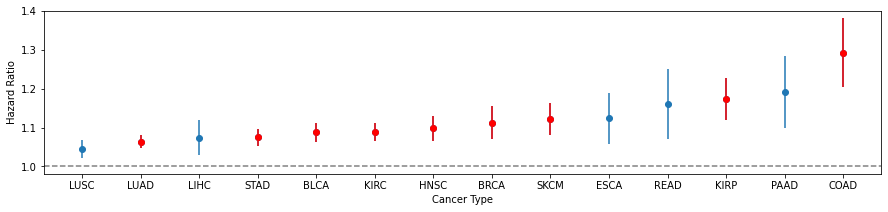

In [365]:
haz_plot_=hazard_list
haz_plot_.index=cancer_list
haz_plot_["Cancer Type"]=cancer_list
haz_plot_=haz_plot_.drop(haz_plot_.index[abs(haz_plot_["coef"])>1][0])
haz_plot_=fdr(haz_plot_,False,"p")
haz_plot_=haz_plot_.sort_values(by="exp(coef)",ascending=True)
plt.figure(figsize=(15,3))
plt.errorbar(x=haz_plot_["Cancer Type"].tolist(),y=haz_plot_["exp(coef)"].tolist(),yerr=haz_plot_["se(coef)"].tolist(),fmt="o")
haz_plot_thresh=haz_plot_[haz_plot_["fdr"]<0.05]
plt.errorbar(x=haz_plot_thresh["Cancer Type"].tolist(),y=haz_plot_thresh["exp(coef)"].tolist(),yerr=haz_plot_thresh["se(coef)"].tolist(),fmt="o",color="red")
plt.xlabel("Cancer Type")
plt.ylabel("Hazard Ratio")
plt.axhline(1,linestyle="--",color="gray")
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/cancer_risk_OS_hazardV2_long.pdf")

In [366]:
len(all_survival_snps["snps"].unique())

299

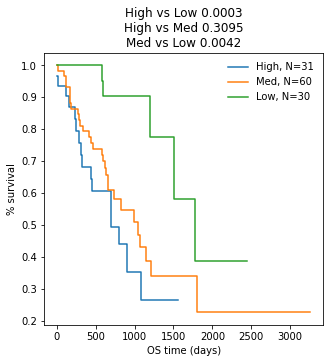

In [138]:
def kaplan_plot_lung(df,cancers):
    
    surv_df_canc=df

    fig=plt.figure(figsize=(5,5))
    ax1 = plt.subplot(1,1,1)

    quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
    surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])
    
    kmf = KaplanMeierFitter()
    kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
    kmf.plot(ci_show=False, ax=ax1)
    kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
    kmf.plot(ci_show=False, ax=ax1)
    kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
    kmf.plot(ci_show=False, ax=ax1)
    
    results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
    results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
    results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

    plt.ylabel('% survival')
    plt.xlabel('OS time (days)')
    plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
    plt.legend(frameon=False)
    
kaplan_plot_lung(test_df_coxPH,"LUAD")

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/_0.25_0.75_LUAD_OS_KM.pdf")
            

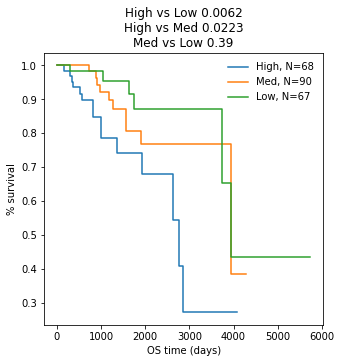

In [142]:
#BRCA
surv_df_canc=test_df_coxPH

fig=plt.figure(figsize=(5,5))
ax1 = plt.subplot(1,1,1)

quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.3,0.7,1])
surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

kmf = KaplanMeierFitter()
kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
kmf.plot(ci_show=False, ax=ax1)

results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

plt.ylabel('% survival')
plt.xlabel('OS time (days)')
plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
plt.legend(frameon=False)
    
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/BRCA_OS_KM.pdf")

            

In [ ]:
#STAD
surv_df_canc=test_df_coxPH

fig=plt.figure(figsize=(5,5))
ax1 = plt.subplot(1,1,1)

quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

kmf = KaplanMeierFitter()
kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
kmf.plot(ci_show=False, ax=ax1)

results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

plt.ylabel('% survival')
plt.xlabel('OS time (days)')
plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
plt.legend(frameon=False)
    
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/STAD_OS_KM.pdf")

            

In [ ]:
#HNSC 
### THE CUTOFFS ARE DIFFERENT HERE!
surv_df_canc=test_df_coxPH

fig=plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)

quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.2,0.8,1])
surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

kmf = KaplanMeierFitter()
kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
kmf.plot(ci_show=False, ax=ax1)

results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

plt.ylabel('% survival')
plt.xlabel('OS time (days)')
plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
plt.legend(frameon=False)

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/HNSC_OS_KM.pdf")

    
            

In [ ]:
#LIHC
surv_df_canc=test_df_coxPH

fig=plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)

quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

kmf = KaplanMeierFitter()
kmf.fit(surv_df_canc[surv_df_canc['group']==2]['OS.time'], surv_df_canc[surv_df_canc['group']==2]['OS'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==1]['OS.time'], surv_df_canc[surv_df_canc['group']==1]['OS'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==0]['OS.time'], surv_df_canc[surv_df_canc['group']==0]['OS'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
kmf.plot(ci_show=False, ax=ax1)

results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)
results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['OS.time'], surv_df_canc[surv_df_canc["group"]==1]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['OS'], alpha=.95)
results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['OS.time'], surv_df_canc[surv_df_canc["group"]==0]['OS.time'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['OS'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['OS'], alpha=.95)

plt.ylabel('% survival')
plt.xlabel('OS time (days)')
plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
plt.legend(frameon=False)
    
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/LIHC_OS_KM.pdf")

            

### Export LUAD RSIDs

In [183]:
#get LUAD SNPs and merge with df that has RSID info
surv_fdr_LUAD=surv_fdr[surv_fdr["cancer"]=="LUAD"]
surv_fdr_LUAD=surv_fdr_LUAD[surv_fdr_LUAD["logrank p"]<0.05]
surv_fdr_LUAD["snps"]=[x.split("_")[0] for x in surv_fdr_LUAD["snps"]]

snps_rsid=snps[["rsid","snps"]]
luad_rsid=pd.merge(surv_fdr_LUAD,snps_rsid,on="snps",how="left")
#luad_rsid["rsid"].drop_duplicates().to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/LUAD_OS_PFI_rsid.txt",header=None,index=None)
luad_rsid.to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/LUAD_OS_PFI_rsid.txt",index=None,sep="\t")

### Validation

In [15]:
sherlock=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/Sherlock_WGS_232_Gentoype_info.txt",sep="\t")

In [16]:
#SNPs need to match the minor allele that we called, for example, 21:46328099:C:T is reversed. The way to tell is raw=21:46328099:C:T_T vs sherlock=21:46328099:C:T 
# yet 1/1	CC, where our call for that would be 1/1 = TT
# Therefore, whenever there is discord like that you need to flag the SNP that needs to be switched.

In [17]:
#sherlock
raw_snp_filt=raw.filter(like=":")
raw_snp_cols=pd.DataFrame(raw_snp_filt.columns.values)
raw_snp_cols["snp"]=raw_snp_cols[0].str.rsplit("_",2).str[0]
raw_snp_cols["alt"]=raw_snp_cols[0].str.rsplit("_",2).str[1]

NameError: name 'raw' is not defined

In [18]:
sherlock_snps=sherlock["snps"].unique()
sherlock_switch=sherlock.copy()

for snp in sherlock_snps:
    #get alt base from sherlock snp
    #get matching alt base from raw dataset
    #flip snps that don't match

    sherlock_filt=sherlock[sherlock["snps"]==snp]
    sherlock_filt=sherlock_filt[sherlock_filt["Genotype_wgs"]=="1/1"]
    if sherlock_filt.shape[0]>0:
        letter=sherlock_filt["Genotype2_wgs"].unique()[0]
        letter=letter[0]

        raw_snp_cols_subset=raw_snp_cols[raw_snp_cols["snp"]==snp]
        raw_snp_cols_subset=raw_snp_cols_subset["alt"]
        raw_snp_letter=raw_snp_cols_subset.iloc[0]
    
        if letter==raw_snp_letter:
            sherlock_switch.loc[sherlock_switch["snps"]==snp,"Genotype_wgs"]=sherlock_switch.loc[sherlock_switch["snps"]==snp,"Genotype_wgs"].map({"0/0":"1/1","0/1":"0/1","1/1":"0/0"})
        
#change 0/1, 1/1 genotype etc to 0,1,2
sherlock_switch["Genotype_wgs"]=sherlock_switch["Genotype_wgs"].map({"0/0":0,"0/1":1,"1/1":2})


    

NameError: name 'raw_snp_cols' is not defined

In [ ]:
sherlock_switch_wide=pd.pivot(sherlock_switch, index="Tumor_Barcode", columns="snps", values="Genotype_wgs")

In [ ]:
#Transform sherlock dataset into dataset to feed into model
#Incorporate clinical data

sherlock_clinical=pd.read_csv("/cellar/users/tsears/projects/germline-immune/data/fig6/Sherlock_WGS_232_clinical_info.txt",sep="\t")

#categorically encode covariates

#subset by adenocarcinomas?

#consider dropping pts with no AGE and/or with no survival data?

sherlock_clinical["stage I"]=0
sherlock_clinical.loc[(np.logical_or(sherlock_clinical["stage"]=="IA",sherlock_clinical["stage"]=="IB")),"stage I"]=1

sherlock_clinical["stage II"]=0
sherlock_clinical.loc[sherlock_clinical["stage"]=="II","stage II"]=1

sherlock_clinical["stage III"]=0
sherlock_clinical.loc[sherlock_clinical["stage"]=="III","stage III"]=1

del sherlock_clinical["stage"]
del sherlock_clinical["stage_info"]

#merge clinical data with genotype data
sherlock_validation=pd.merge(sherlock_switch_wide,sherlock_clinical,left_index=True,right_on="Tumor_Barcode")

#Filter by histology and lack of survival data, also fill in missing age with mean of other pts
sherlock_validation=sherlock_validation.loc[sherlock_validation["survival_months"].notna(),:]
sherlock_validation["gender"].replace(['Female', 'Male'],
                        [1, 0], inplace=True)
sherlock_validation["passive_smoking"].replace(['N', 'Y'],
                        [0, 1], inplace=True)

sherlock_validation=sherlock_validation.loc[sherlock_validation["Histology"]=="Adenocarcinomas",:]
sherlock_validation['age_at_diagnosis'].fillna((sherlock_validation['age_at_diagnosis'].mean()), inplace=True)


### Reload LUAD model for verification

In [ ]:
#Create grand for loop to produce plots for everything
from sklearn.linear_model import Lasso
import sklearn.metrics as metrics
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
    
#Loop through lasso, drop snps, input list of hyperparams as well as respective cancer types
#store coxph outcomes into final df for easy final plotting
#run for loop by index and use 3 separate lists for input info?

#### part 1, lasso model ####
cancer_list=cov_col_table["index"]
cancer_list=cancer_list.drop("TGCT")

cancer_list=["LUAD"]
alphas=[0.00045] #alpha from ensemble model

hazard_list_luad=pd.DataFrame()

for i in range(len(cancer_list)):
    
    surv_fdr_drop=surv_fdr[surv_fdr["cancer"]==cancer_list[i]]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["survival"]=="OS"]
    surv_fdr_drop=surv_fdr_drop[surv_fdr_drop["logrank p"]<0.05]
    
    cols_to_drop=np.setdiff1d(os_train_beta.filter(like=":").columns.values.tolist(),surv_fdr_drop["snps"].to_list()).tolist() 
    
    #for LUAD add snps relating to GGH and DHFR for supplementary figure drop AFTER lasso
    #cols_to_drop=cols_to_drop+["5:79618047:C:T_T","5:79955991:T:G_G","8:63935457:T:C_C","8:63976677:C:T_T",]
    
    train_df=os_train_beta[os_train_beta["cancer"]==cancer_list[i]]
    test_df=os_test_beta[os_test_beta["cancer"]==cancer_list[i]]
    
    train_df=train_df.drop(cols_to_drop,axis=1)
    test_df=test_df.drop(cols_to_drop,axis=1)
    
    print(train_df.shape)
    
    train_y=train_df["OS"]
    test_y=test_df["OS"]
    
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")

    #pd.Series(train_x.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig5/"+cancer_list[i]+"_filtered_SNP_list_OS.txt",sep="\t",index=False,header=False)
                                       
    #filter using LASSO regression

    # define mode
    model = Lasso(alpha=alphas[i],random_state=random_state)
    # fit model
    model.fit(train_x, train_y)
    p = model.predict(train_x)  # test the output by changing values

    #Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions
    # calculate the fpr and tpr for all thresholds of the classification
    #preds = np.around(p, decimals=0, out=None)

    preds=p

    fpr, tpr, threshold = metrics.roc_curve(list(test_y), preds,pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    print(roc_auc)
    import matplotlib.pyplot as plt

    #### part 2 ####

    #remake SNP list with dropped "useless" SNPs
    print("SNPs dropped = ",len(train_x.columns.values[model.coef_==0].tolist()),"out of ",len(train_x.columns.values))
    train_df=train_df.drop(train_x.columns.values[model.coef_==0].tolist(),axis=1)
    test_df=test_df.drop(test_x.columns.values[model.coef_==0].tolist(),axis=1)
    
    #re-drop non cancer-related snps as well
    train_x=train_df.filter(like=":")
    test_x=test_df.filter(like=":")
    
    regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 300, random_state = random_state,learning_rate=0.5,max_depth=9)
    regressor_xgb.fit(train_x, train_y)  

    p = regressor_xgb.predict(test_x)  # test the output by changing values
    p_disc=regressor_xgb.predict(train_x)

    test_df["LASSO_burden"]=p*100
    train_df["LASSO_burden"]=p_disc*100

    #fig = plt.figure(figsize=(5,5))

    #sns.violinplot(x="OS",y="LASSO_burden",data=test_df)

    cat1 = test_df[test_df["OS"]==0]
    cat2 = test_df[test_df["OS"]==1]
    print("mannWhitnetPredScore=",stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

    #plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

    #plt.ylabel("burden (pvalue < 0.05) RF Regression")
    #plt.xticks(rotation=90)
    #plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/"+cancer_list[i]+"violinplot.pdf")

    #now do hazard plot on PRS scores generated...
    test_df_coxPH=test_df[list(np.append(['Stage II', 'Stage III', 'Stage I','ajcc_pathologic_tumor_stage',
            'OS', 'OS.time',
           'age_at_initial_pathologic_diagnosis',
           'LASSO_burden'],cov_col_table.loc[cancer_list[i],1]))]
    
    #filter covariates that throw errors due to low variance
    test_df_coxPH=test_df_coxPH.drop(list(test_df_coxPH.var().index[test_df_coxPH.var()<0.01]),axis=1) #seems to be necessary
    test_df_coxPH=test_df_coxPH.fillna(0)

    cph = CoxPHFitter(penalizer=0.01)

    cph.fit(test_df_coxPH, duration_col = 'OS.time', event_col = 'OS')
    print(cancer_list[i])
    #cph.print_summary()
    print(cph.summary.loc["LASSO_burden"])
    
    hazard_list_luad=hazard_list_luad.append(cph.summary.loc["LASSO_burden"])

    
    

In [444]:
features = train_x.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snps","rsid"]]

mapping_table["ID2"]=[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in mapping_table["ID"].tolist()]

compiled_icb_rsid=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snps")
compiled_icb_rsid2=pd.merge(mapping_table,rsid_table,left_on="ID2",right_on="snps")

compiled_icb_rsid_plot=pd.concat([compiled_icb_rsid,compiled_icb_rsid2],axis=0)
compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

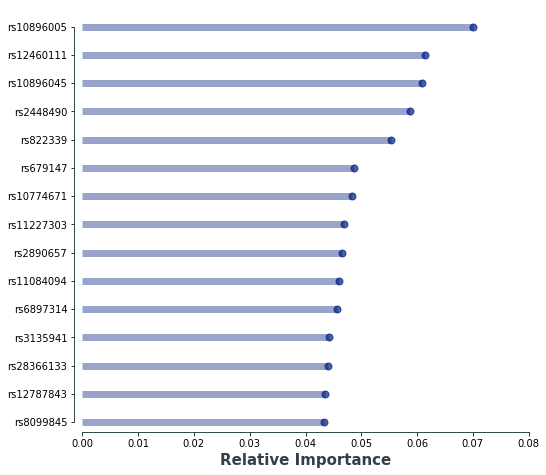

In [445]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.08)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/surv_feature_importance_V2.pdf",bbox_inches = "tight")


In [ ]:
#Now validate in sherlock using the same features and as many similar covariates as possible

#get SNPs that were included in model:
sherlock_snps_to_keep=train_x.columns.values
sherlock_snps_to_keep=[x.split("_")[0] for x in sherlock_snps_to_keep]
sherlock_test=sherlock_validation[sherlock_snps_to_keep]

In [ ]:
#Apply betas from test dataset

#this is from earlier in the run
df_coxph_rows=df_coxph.index
df_coxph["snp_short"]=[x.rsplit("_",2)[0] for x in df_coxph_rows]
df_coxph_train_LUAD=df_coxph[df_coxph["cancer"]=="LUAD"]

for i,row in df_coxph_train_LUAD.iterrows():
    if row["snp_short"] in sherlock_test and not np.isnan(row["coef"]):
        sherlock_test[row["snp_short"]]=sherlock_test[row["snp_short"]]*row["coef"]
        

In [ ]:

#get OS information
sherlock_OS=sherlock_validation["death"]
p = regressor_xgb.predict(sherlock_test) 
sherlock_validation["LASSO_burden"]=p*100

#mann whitney test
cat1 = sherlock_validation[sherlock_validation["death"]==0]
cat2 = sherlock_validation[sherlock_validation["death"]==1]
print("mannWhitnetPredScore=",stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

#hazard plot with covariates that made it into LUAD model
test_df_coxPH=sherlock_validation[['stage II', 'stage III', 'stage I',
           'gender','age_at_diagnosis','grade', 'passive_smoking', 'death',
           'survival_months','LASSO_burden']]
    
#filter covariates that throw errors due to low variance
test_df_coxPH=test_df_coxPH.drop(list(test_df_coxPH.var().index[test_df_coxPH.var()<0.01]),axis=1) #seems to be necessary
test_df_coxPH=test_df_coxPH.fillna(0)

cph = CoxPHFitter(penalizer=0.01)

cph.fit(test_df_coxPH, duration_col = 'survival_months', event_col = 'death')
#print(cancer_list[i])
#cph.print_summary()
print(cph.summary.loc["LASSO_burden"])

#KM plot with top/bottom quantiles
surv_df_canc=sherlock_validation

fig=plt.figure(figsize=(5,5))
ax1 = plt.subplot(1,1,1)

quantiles=np.quantile(surv_df_canc["LASSO_burden"],[0,0.25,0.75,1])
surv_df_canc['group'] = pd.cut(surv_df_canc["LASSO_burden"], quantiles, labels=[0,1,2])

kmf = KaplanMeierFitter()
kmf.fit(surv_df_canc[surv_df_canc['group']==2]['survival_months'], surv_df_canc[surv_df_canc['group']==2]['death'],label="High, N="+str(surv_df_canc[surv_df_canc['group']==2].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==1]['survival_months'], surv_df_canc[surv_df_canc['group']==1]['death'],label="Med, N="+str(surv_df_canc[surv_df_canc['group']==1].shape[0]))
kmf.plot(ci_show=False, ax=ax1)
kmf.fit(surv_df_canc[surv_df_canc['group']==0]['survival_months'], surv_df_canc[surv_df_canc['group']==0]['death'],label="Low, N="+str(surv_df_canc[surv_df_canc['group']==0].shape[0]))
kmf.plot(ci_show=False, ax=ax1)

results = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['survival_months'], surv_df_canc[surv_df_canc["group"]==0]['survival_months'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['death'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['death'], alpha=.95)
results2 = logrank_test(surv_df_canc[surv_df_canc["group"]==2]['survival_months'], surv_df_canc[surv_df_canc["group"]==1]['survival_months'],event_observed_A=surv_df_canc[surv_df_canc["group"]==2]['death'], event_observed_B=surv_df_canc[surv_df_canc["group"]==1]['death'], alpha=.95)
results3 = logrank_test(surv_df_canc[surv_df_canc["group"]==1]['survival_months'], surv_df_canc[surv_df_canc["group"]==0]['survival_months'],event_observed_A=surv_df_canc[surv_df_canc["group"]==1]['death'], event_observed_B=surv_df_canc[surv_df_canc["group"]==0]['death'], alpha=.95)

plt.ylabel('% survival')
plt.xlabel('OS time (days)')
plt.title("High vs Low "+str(np.round(results.p_value,4))+"\n"+"High vs Med "+str(np.round(results2.p_value,4))+"\n"+"Med vs Low "+str(np.round(results3.p_value,4)))
plt.legend(frameon=False)

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/SHERLOCK_QUARTILE_OS_KM_alpha_65.pdf")

hazard_list_luad=hazard_list_luad.append(cph.summary.loc["LASSO_burden"])


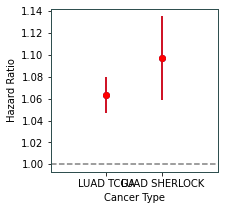

In [389]:


haz_plot_=hazard_list_luad
haz_plot_.index=["LUAD TCGA","LUAD SHERLOCK"]
haz_plot_["Cancer Type"]=["LUAD TCGA","LUAD SHERLOCK"]
#haz_plot_=haz_plot_.drop(haz_plot_.index[abs(haz_plot_["coef"])>1][0])
#haz_plot_=haz_plot_.drop("THCA")
haz_plot_=fdr(haz_plot_,False,"p")
haz_plot_=haz_plot_.sort_values(by="exp(coef)",ascending=True)
plt.figure(figsize=(3,3))
plt.xticks([0,1])
plt.xlim((-1, 2))
plt.errorbar(x=haz_plot_["Cancer Type"].tolist(),y=haz_plot_["exp(coef)"].tolist(),yerr=haz_plot_["se(coef)"].tolist(),fmt="o")
haz_plot_thresh=haz_plot_[haz_plot_["fdr"]<0.05]
plt.errorbar(x=haz_plot_thresh["Cancer Type"].tolist(),y=haz_plot_thresh["exp(coef)"].tolist(),yerr=haz_plot_thresh["se(coef)"].tolist(),fmt="o",color="red")
plt.xlabel("Cancer Type")
plt.ylabel("Hazard Ratio")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/LUAD_sherlock_hazardV2.pdf")

